## 2. Softmax分类模型

### 2.1 softmax基本概念

Softmax回归看作是Logistics回归的扩展. 类别为2时,Softmax回归就可以看作是Logistics回归. 

既然是多分类问题,那么Softmax回归的输出单元有多个,而且经过一个特殊的softmax()激活函数,输出值就变为正且和为1的概率分布.

$$ \textbf O = \textbf X \textbf W + \textbf b $$
$$ \hat{Y} = softmax(O_i) $$

其中$$ softmax(o_i)=\frac{exp(o_i)}{\sum_jexp(o_j)} $$

损失函数
$$ L(\theta)=-\frac{1}{m}\left[\sum_{i=1}^{m} \sum_{j=1}^{k} 1\left\{y_{i}=j\right\} \log \frac{e^{\theta_{j}^{T} x_{i}}}{\sum_{l=1}^{k} e^{\theta_{l}^{T} x_{i}}}\right] $$
其中，1{·}是示性函数，即1{值为真的表达式}=1，1{值为假的表达式}=0。跟 logistic 函数一样，利用梯度下降法最小化代价函数，下面求解 $\theta$ 的梯度。

$L(\theta)$ 关于 $\theta_{j}$ 的梯度求解为:
<img src="https://cdn.mathpix.com/snip/images/4cbg7f1TxsDaGoUhxIh9WHImVSJUvZ8G2ckGUduljR8.original.fullsize.png">

### 2.2 获取FasionMINIST数据集

In [1]:
#导包
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import time
import sys
sys.path.append("..")#为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [2]:
# # 获得数据
mnist_train = torchvision.datasets.FashionMNIST(root='E:/Datasets/', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='E:/Datasets/', train=False, download=False, transform=transforms.ToTensor())
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [3]:
#如果不做变换-输入的数据是图像，我们可以看一下图片的类型参数：
mnist_PIL = torchvision.datasets.FashionMNIST(root='E:/Datasets', train=True, download=False)
PIL_feature, label = mnist_PIL[0]
print(PIL_feature)

<PIL.Image.Image image mode=L size=28x28 at 0x2BF6DEA1D68>


In [4]:
# 我们可以通过下标来访问任意一个样本
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width

torch.Size([1, 28, 28]) 9


变量feature对应高和宽均为28像素的图像。由于我们使用了transforms.ToTensor()，所以每个像素的数值为[0.0, 1.0]的32位浮点数。需要注意的是，feature的尺寸是 (C x H x W) 的，而不是 (H x W x C)。第一维是通道数，因为数据集中是灰度图像，所以通道数为1。后面两维分别是图像的高和宽。

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

看一下训练数据集中前10个样本的图像内容和文本标签

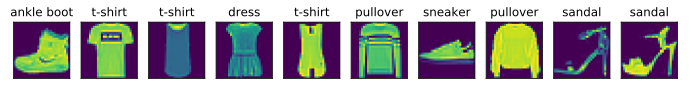

In [6]:
#定义一个可以在一行里画出多张图像和对应标签的函数
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

# 开始读取
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

使用torch.utils.data.DataLoader进行小批量读取

为了提高读取效率设定参数num_workers

In [7]:
batch_size = 256
num_workers = 4 #设置为4个进程
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#查看一下完整读取所需要的时间
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.79 sec


### 2.2 Softmax从零开始实现

In [8]:
# 导入包
import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

# 读取数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

初始化模型参数

模型的输入向量的长度是 28\*28=784,该向量的每个元素对应图像中每个像素。
由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为784\*10和1\*10的矩阵

In [9]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

实现softmax运算
$$ softmax(o_i)=\frac{exp(o_i)}{\sum_jexp(o_j)} $$

In [10]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

softmax回归模型
$$ o_i =  x_i \textbf W + \textbf b $$
$$ \hat{Y} = softmax(o_i) $$

In [11]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

定义损失函数
$$ H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)} $$

$$\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right )$$

$$\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}$$

In [12]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

定义准确率

In [13]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()


# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

训练模型

In [14]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step() 
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7843, train acc 0.751, test acc 0.790
epoch 2, loss 0.5719, train acc 0.812, test acc 0.813
epoch 3, loss 0.5253, train acc 0.826, test acc 0.816
epoch 4, loss 0.5013, train acc 0.832, test acc 0.823
epoch 5, loss 0.4860, train acc 0.837, test acc 0.825


模型预测

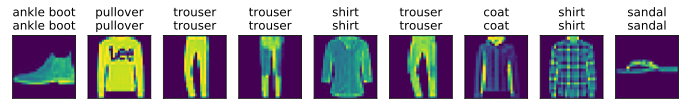

In [15]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

### 2.4 Softmax简介实现

In [16]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("...")
import d2lzh_pytorch as d2l

print(torch.__version__)

#初始化参数和获取数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
#定义网络模型
num_inputs = 784
num_outputs = 10
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x 的形状: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y
    
# net = LinearNet(num_inputs, num_outputs)

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x 的形状: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

from collections import OrderedDict
net = nn.Sequential(
        # FlattenLayer(),
        # LinearNet(num_inputs, num_outputs) 
        OrderedDict([
           ('flatten', FlattenLayer()),
           ('linear', nn.Linear(num_inputs, num_outputs))]) # 或者写成我们自己定义的 LinearNet(num_inputs, num_outputs) 也可以
        )

#初始化模型参数
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

1.4.0


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [17]:

#定义损失函数
loss = nn.CrossEntropyLoss() # 下面是他的函数原型
# class torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

#定义优化函数
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # 下面是函数原型
# class torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)

#训练
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.751, test acc 0.784
epoch 2, loss 0.0022, train acc 0.814, test acc 0.810
epoch 3, loss 0.0021, train acc 0.825, test acc 0.812
epoch 4, loss 0.0020, train acc 0.833, test acc 0.818
epoch 5, loss 0.0019, train acc 0.837, test acc 0.799


### 2.5 课后作业

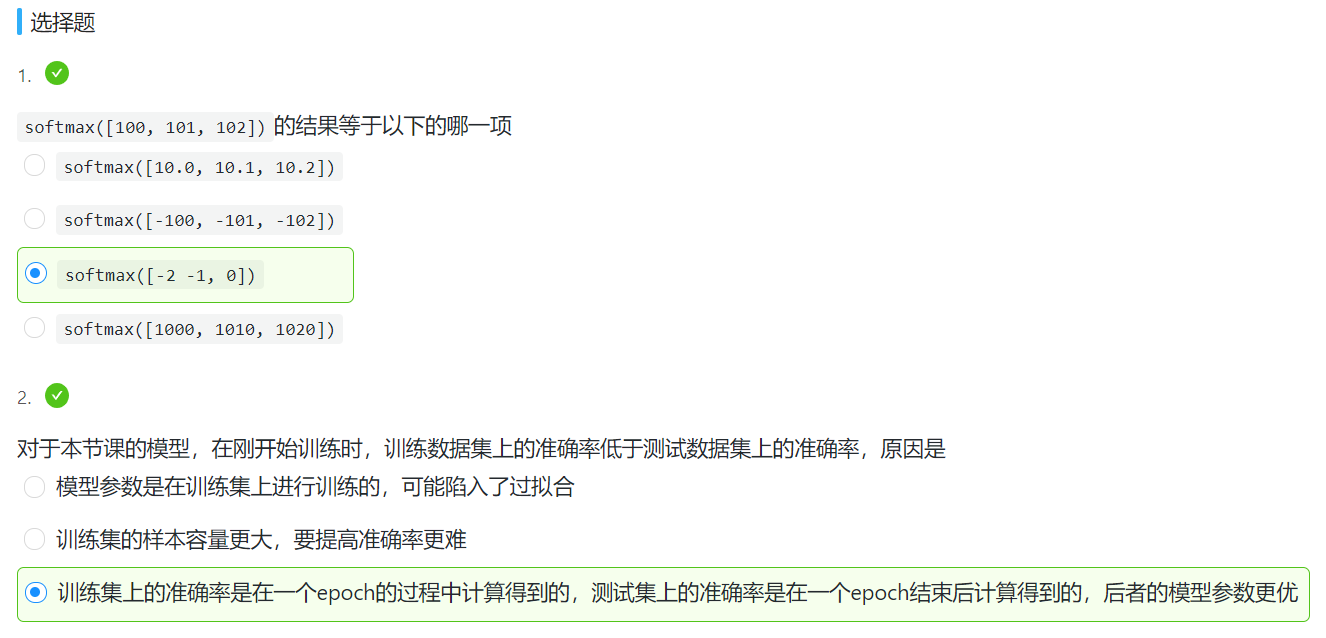